In [103]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMFDiscTau import ShiftNMF
from torchShiftAA import torchShiftAA
from torchShiftAADiscTau import torchShiftAADisc
import torch
from helpers.callbacks import explained_variance
import scipy.io

## Data

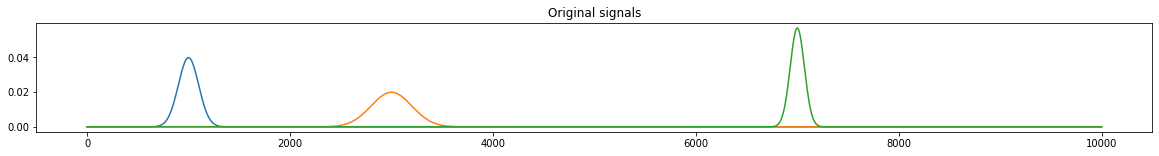

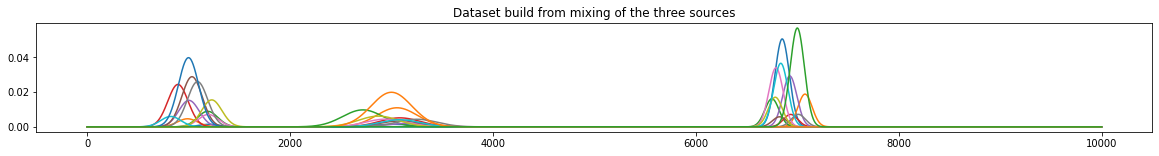

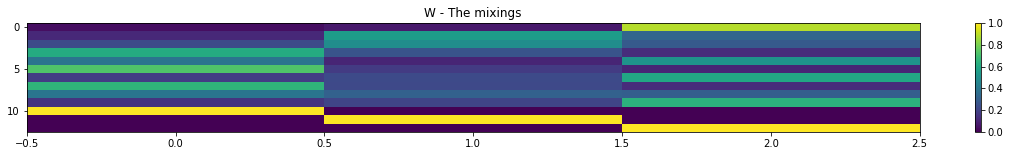

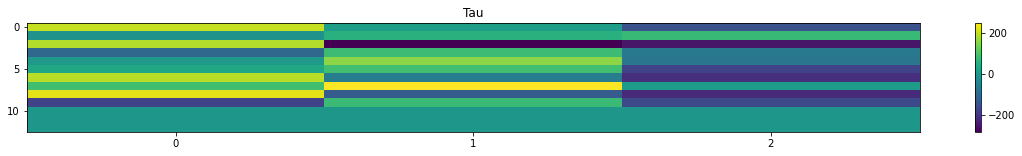

Tau Norm:  823.4045178404111


In [104]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 10, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

shift = 300

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V


# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
W = np.append(W, [[1,0,0]], axis=0)
W = np.append(W, [[0,1,0]], axis=0)
W = np.append(W, [[0,0,1]], axis=0)
N = N+3

# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N-3, d))
#append 3x3 matrix of zeros to tau
tau = np.append(tau, [[0,0,0],[0,0,0],[0,0,0]], axis=0)
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [100, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)
X_clean = shift_dataset(W, H, np.zeros((N, d)))


plt.figure()
for signal in X:
    plt.plot(signal.real)
plt.title("Dataset build from mixing of the three sources")
plt.show()
plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
plt.title("W - The mixings")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()


print("Tau Norm: ", np.linalg.norm(tau))

## Sinc-interpolation

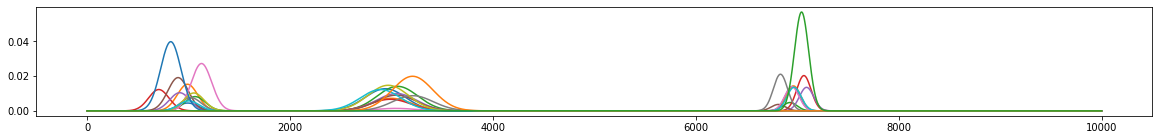

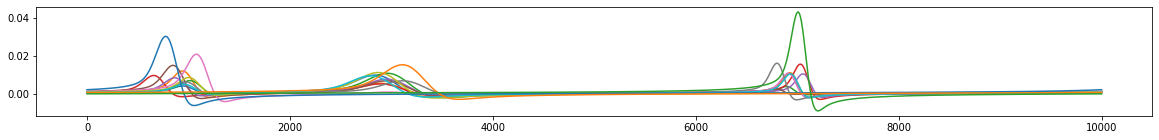

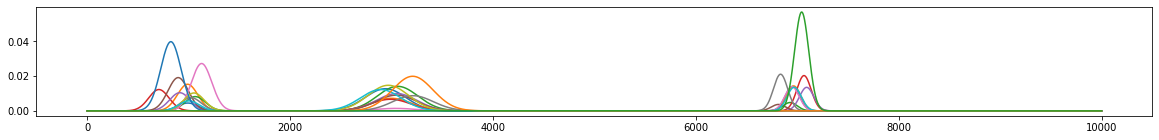

In [105]:
tau_0 = np.round(np.random.randn(N, d)*100)
tau_half = tau_0 + 0.2
tau_1 = tau_0 + 1

N, M, d = 10, 10000, 3

W_sinc = np.random.dirichlet(np.ones(d), N)
W_sinc = np.append(W_sinc, [[1,0,0]], axis=0)
W_sinc = np.append(W_sinc, [[0,1,0]], axis=0)
W_sinc = np.append(W_sinc, [[0,0,1]], axis=0)
N += 3
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])

X_0 = shift_dataset(W_sinc, H, tau_0)
X_half = shift_dataset(W_sinc, H, tau_half)
X_1 = shift_dataset(W_sinc, H, tau_1)

plt.plot(X_0.T)
plt.show()
plt.plot(X_half.T)
plt.show()
plt.plot(X_1.T)
plt.show()

In [106]:
print(explained_variance(X_0, X_1))
print(explained_variance(X_half, X_1))

(0.9999380307978167+4.4433714367950705e-18j)
(0.9953404328408155-0.0033853737032444866j)


## Regular NMF

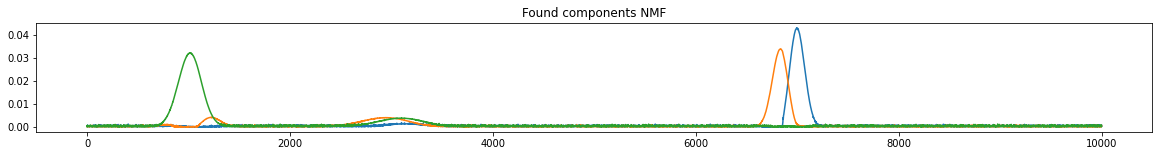

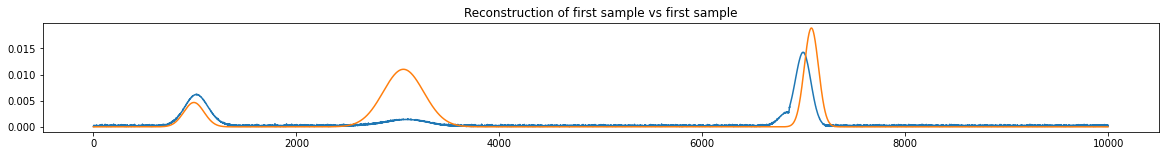

In [107]:

nmf = NMF(X, 3, lr=0.01, factor=0.9, alpha=1e-6)
W_reg, H_reg = nmf.fit(verbose=True)
recon_reg = np.matmul(W_reg, H_reg)

for signal in H_reg:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon_reg[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

In [108]:

nmf_s = ShiftNMF(X, 3, lr=0.3, factor=0.9)
W_s, H_s, tau_shift = nmf_s.fit(verbose=True, tau_iter=0, tau_thres=1e-5)

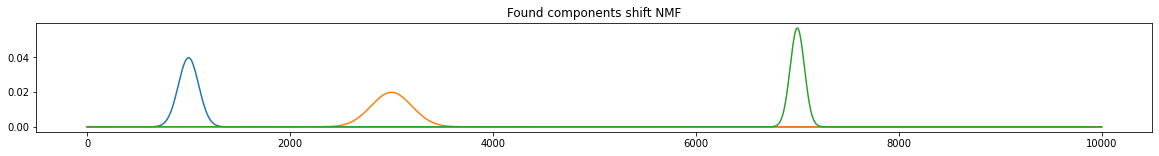

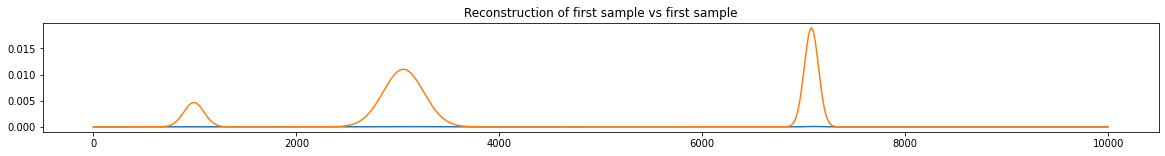

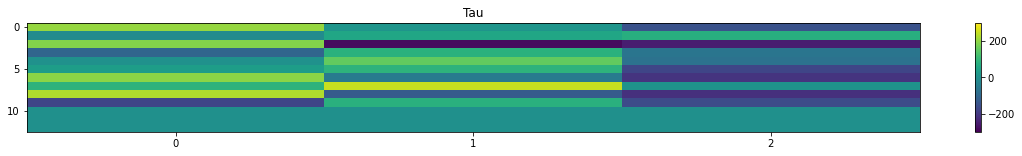

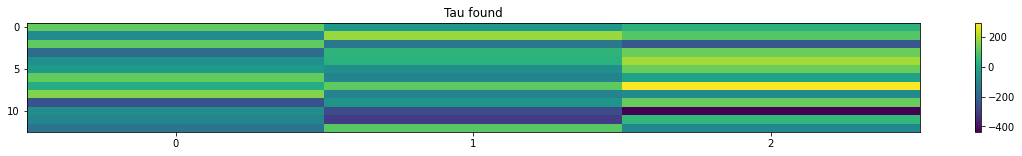

In [109]:
recon_s = nmf_s.recon.detach().numpy()
# print(explained_variance(X.real, recon_s.real))
for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon_s[1]*nmf.std.detach().numpy())
# plt.show()
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau[:13], aspect='auto', interpolation="none", vmin=-shift, vmax=shift)
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()


plt.figure()
plt.imshow(tau_shift[:13], aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau found")
plt.show()

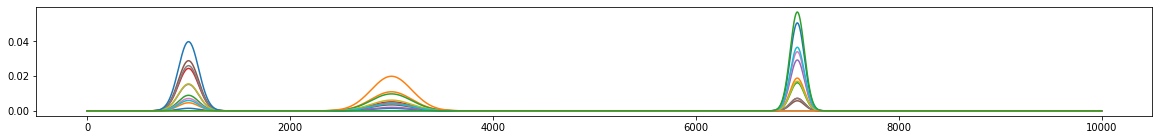

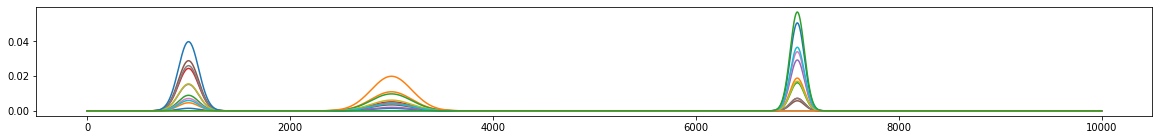

In [110]:
plt.rcParams['figure.figsize'] = [20, 2]
plt.plot(np.matmul(W,H).T)
plt.show()
plt.plot(X_clean.T)
plt.show()

## Regular AA

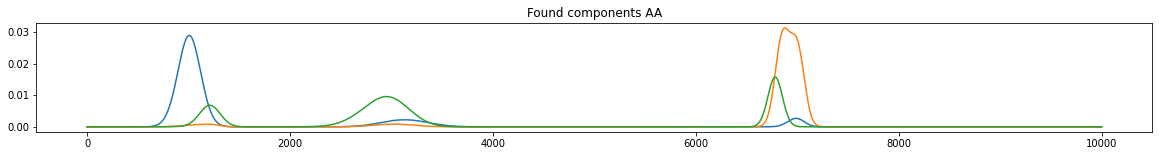

In [111]:
AA = torchAA(X, 3, patience = 10, alpha=1e-6, lr=0.3)
# AA.C = C_init
# AA.S = S_init
C_AA, S_AA = AA.fit(verbose=True)
CX = np.matmul(C_AA, X)
recon_AA = np.matmul(S_AA, CX)

plt.rcParams['figure.figsize'] = [20, 2]
for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()



# plt.plot(recon[1])
# plt.plot(X[1])
# plt.title("Reconstruction of first sample vs first sample (AA)")
# plt.show()

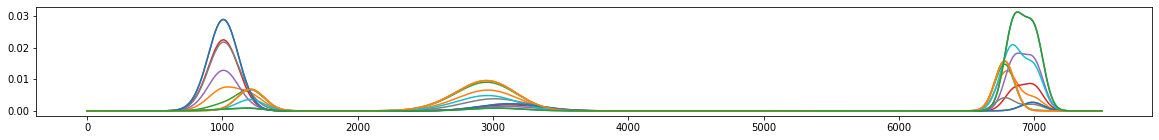

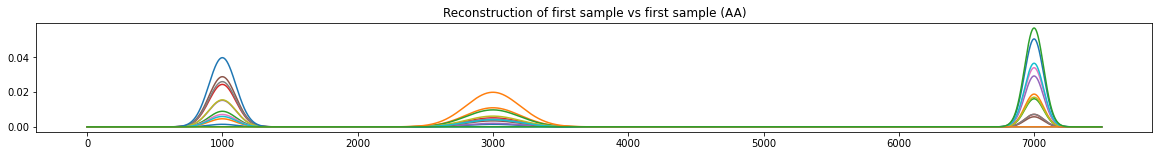

In [112]:
plt.plot(recon_AA.T[:7500])
plt.show()
plt.plot(X_clean.T[:7500])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

## Shift AA

In [113]:
shiftAA = torchShiftAADisc(X, 3, lr=0.4, patience=5, alpha=1e-5, factor=0.95, fs_init=False)
C_s, S_s, tau_AA_shift = shiftAA.fit(verbose=True, tau_thres=1e-5)

c:\Users\lucas\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


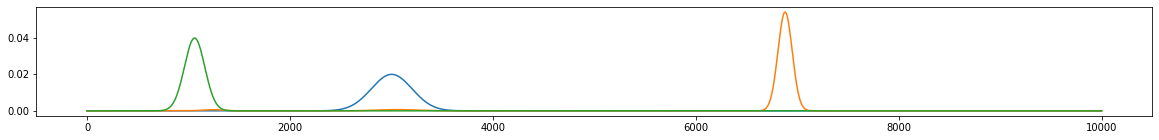

In [116]:

recon = shiftAA.recon.detach().resolve_conj().numpy()
A_s = torch.fft.ifft(shiftAA.A_F).detach().numpy()

# A_mm = np.matmul(AA.C().detach().numpy(), X)

CX = A_s
SCX = recon

recon_no_shift = np.matmul(S_s,A_s)

# for signal in A:
plt.plot(A_s.T)
# plt.title("Found components AA")
# plt.show()

# plt.plot(X_clean[-3:].T)
# plt.title("Original Components")
plt.show()

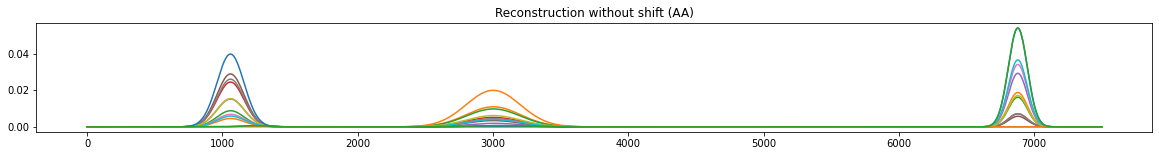

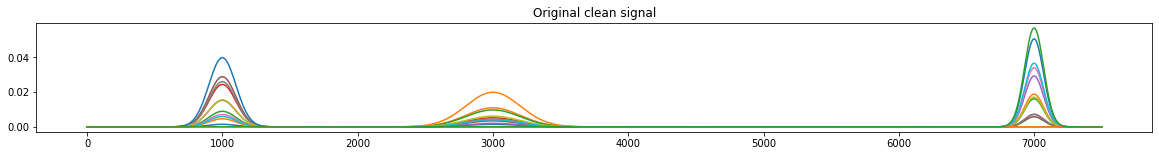

In [117]:
lim = 7500

plt.plot(recon_no_shift.T[:lim])
plt.title("Reconstruction without shift (AA)")
plt.show()
# plt.plot(recon_reg.T[:lim])
# plt.show()
plt.plot(X_clean.T[:lim])
plt.title("Original clean signal")
plt.show()

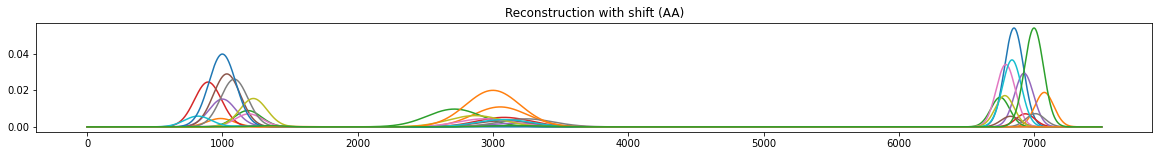

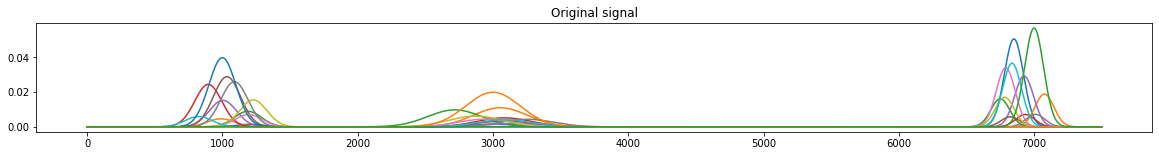

In [118]:
plt.plot(recon.T[:lim])
plt.title("Reconstruction with shift (AA)")
plt.show()
# plt.plot(recon_reg.T[:lim])
# plt.show()
plt.plot(X.T[:lim])
plt.title("Original signal")
plt.show()

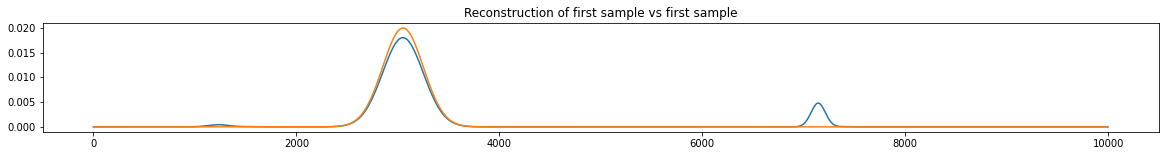

In [ ]:
plt.plot(recon[11])
plt.plot(X[11])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

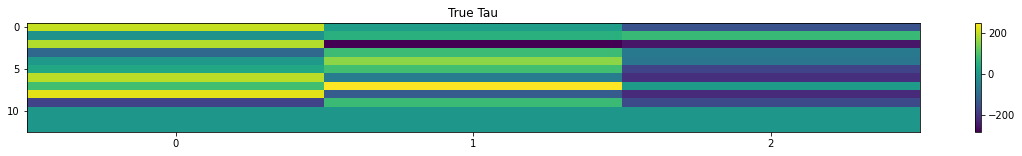

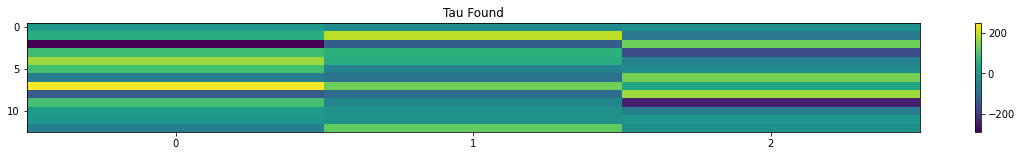

In [119]:
# plt.figure()
plt.imshow(tau[:13], aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("True Tau")
plt.show()

plt.figure()
plt.imshow(tau_AA_shift[:13], aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau Found")
plt.show()

In [ ]:
def AA_recon(S_aa, C_aa, X_dat, tau_found):
    N, M = X_dat.shape
    
    f = np.arange(0, M) / M
    
    omega = np.exp(-2j * np.pi * np.einsum('Nd,M->NdM', tau_found, f))
    omega_conj = np.conj(omega)
    
    X_F = np.fft.fft(X_dat)
    
    X_F_align = np.einsum('NM,NdM->NdM', X_F, omega_conj)
    
    A_F = np.einsum('dN,NdM->dM', C_aa, X_F_align)
    S_shift = np.einsum('Nd,NdM->NdM', S_aa, omega)
    
    x = np.einsum('NdM,dM->NM', S_shift, A_F)
    return np.fft.ifft(x)

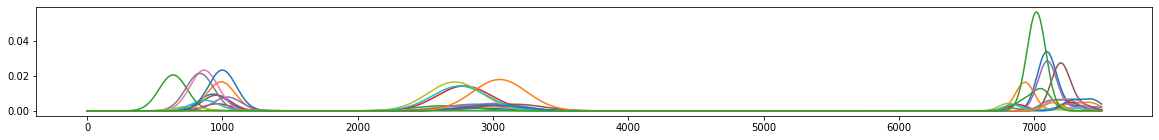

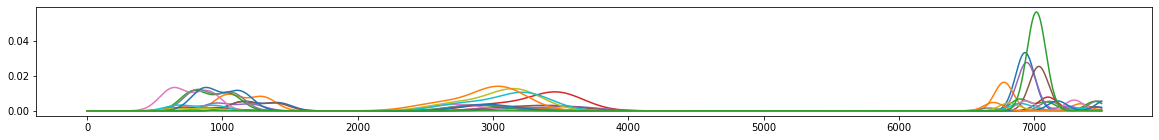

In [ ]:
# X_rec_func = AA_recon(S, C, X, _)

plt.plot(AA_recon(S, C, X, tau_AA_shift).T[:lim])
plt.show()
plt.plot(AA_recon(S, C, X, tau).T[:lim])
plt.show()

In [ ]:
# np.linalg.norm(AA_recon(S, C, X, tau) - AA_recon(S, C, X, _), ord="fro")**2 / np.linalg.norm(AA_recon(S, C, X, tau) - np.mean(AA_recon(S, C, X, tau)), ord="fro")**2

ValueError: einstein sum subscripts string contains too many subscripts for operand 0

In [ ]:
tau

array([[  81,  241,  121],
       [ -75,  123,  198],
       [  42, -128, -161],
       [ 245, -207,  119],
       [  93,   35,  226],
       [ 182,  223,  149],
       [-108, -281,  296],
       [-189, -106,  114],
       [-100, -285, -189],
       [-154, -242, -119],
       [ 178,  -47,  154],
       [ 140,   51, -300],
       [ 165,   84,   17]])

In [ ]:
#swap column 0 and 1
tau_AA_shift[:,[0, 1]] = tau_AA_shift[:,[1, 0]]

In [ ]:
tau_AA_shift

array([[  62.,   48.,  154.],
       [ -98.,  107.,   87.],
       [  18., -248., -319.],
       [ 229.,   76., -147.],
       [  68.,  152.,   79.],
       [ 163.,   73.,  269.],
       [-132.,  -19.,  -17.],
       [-209.,  -50.,   47.],
       [-255., -152., -213.],
       [-174.,  -16., -181.],
       [ 156.,  116., -185.],
       [  23.,   -1.,  119.],
       [ -13.,  -50.,    7.]])

In [ ]:
#add 100 to the last column
tau_AA_shift[:,-1] -= 200

In [ ]:
C.shape

(3, 13)

In [133]:
#regular nmf
W_reg, H_reg

#shift nmf
W_s, H_s, tau_shift

#regular aa
C_AA,S_AA
#shift aa
C_s,S_s, tau_AA_shift

#data
X
X_clean

#save all variables
np.savetxt("results/notebook_data/W_reg_nmf.txt", W_reg)
np.savetxt("results/notebook_data/H_reg_nmf.txt", H_reg)

np.savetxt("results/notebook_data/W_shift_nmf.txt", W_s)
np.savetxt("results/notebook_data/H_shift_nmf.txt", H_s)
np.savetxt("results/notebook_data/tau_shift_nmf.txt", tau_shift)

np.savetxt("results/notebook_data/C_reg_AA.txt", C_AA)
np.savetxt("results/notebook_data/S_reg_AA.txt", S_AA)

np.savetxt("results/notebook_data/C_shift_aa.txt", C_s)
np.savetxt("results/notebook_data/S_shift_aa.txt", S_s)
np.savetxt("results/notebook_data/tau_shift_AA.txt", tau_AA_shift)

np.savetxt("results/notebook_data/X_with_shifts.txt", X)
np.savetxt("results/notebook_data/X_no_shifts.txt", X_clean)
np.savetxt("results/notebook_data/true_tau.txt", tau)